# Classificaiton with high-order features

The approximation of the kernel trick as described by Rahimi and Recht produces a shift-invariant radial basis function type of kernel, like a Gaussian or sinc function. But there are other types of kernels and features that can be used to project data into a seperable feature space.

Here, we will also examine the connection between higher-order features and binding in vector-symbolic architectures.

In [1]:
import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
import sklearn.datasets
from sklearn.model_selection import train_test_split

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [2]:
%matplotlib inline

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'serif', 
                     'font.serif':['Computer Modern']})

In [3]:
from numpy.fft import fft, ifft

def crvec(N, D=1):
    rphase = 2*np.pi * np.random.rand(int(D), int(N))
    return np.cos(rphase) + 1.0j * np.sin(rphase)

def scvec(N, D, K):
    letter_vectors_c = crvec(N, D)

    for d in range(D):
        ip = np.random.choice(int(N), size=int(N-K), replace=False)
        letter_vectors_c[d, ip] = 0
        
    return letter_vectors_c

def lccvec(N, D, Kv):
    # N needs to be multiple of Kv
    
    R = N/Kv
    
    assert(R==N//Kv)
    
    letter_vectors_c = 0*crvec(N, D)
    
    for d in range(D):
        ip = np.random.choice(int(R), size=int(Kv), replace=True)
        
        ip += int(R) * np.arange(int(Kv))
        
        letter_vectors_c[d, ip] = crvec(Kv, 1)
        
    return letter_vectors_c
    
def cconv(a, b, pa=1, pb=1):
    return ifft(fft(a)**pa * fft(b)**pb)
    
def ccinv(a):
    #return ifft(np.conj(fft(a)))
    return ifft(fft(a)**(-1))

def lccI(Nv, Kv):
    vv = 0.0*crvec(Nv, 1) 
    
    Rv = Nv//Kv
    
    vvr = np.reshape(vv, [int(Kv), int(Rv)])
    
    vvr[:, 0] = 1
    
    return vvr.flatten()    
    
    

def lccbind(vec1, vec2, Kv, pa=1, pb=1):
    Nv = vec1.shape[0]
    Rv = Nv/Kv

    vec1r = np.reshape(vec1, [int(Kv), int(Rv)])
    vec2r = np.reshape(vec2, [int(Kv), int(Rv)])

    vec_br = cconv(vec1r, vec2r, pa, pb)

    vec_b = vec_br.flatten()
    
    return vec_b

def lccperm(vec1, Kv, proll=1):
    Nv = vec1.shape[0]
    Rv = Nv/Kv

    vec1r = np.reshape(vec1, [int(Kv), int(Rv)])
    
    vec_perm = np.roll(vec1r, proll, axis=0)
    
    return vec_perm.flatten()

def lccinv(vec1, Kv):
    Nv = vec1.shape[0]
    Rv = Nv/Kv

    vec1r = np.reshape(vec1, [int(Kv), int(Rv)])
    
    vec1_ir = ccinv(vec1r)
    vec1_i = vec1_ir.flatten()
    
    return vec1_i

## Classification with polynomial features

Here, we will design a classifier based on the higher order features of the data. Higher-order features are extracted by multiplying together the lower-order features. We would call the input features the "linear" or "first-order" feature space, and any pair-wise products of these features would form "quadratic" or "second-order" features. This can continue with "third-order", "fourth-order", etc. with three products between linear features, four products, etc., respectively. 

The second-order features would then be enumerated by the tensor product between the linear vectors.  we are going to just treat each number in the tensor product as a feature. Lets enumerate the higher order features then into the data vectors and again just perform our linear regression classifier. 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


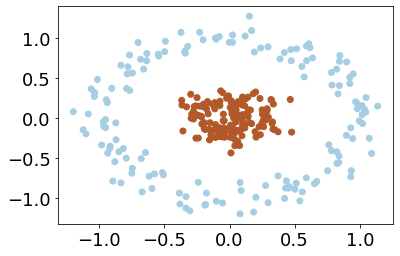

In [4]:
# sklearn has some simple datasets
n = 300
X, y = sklearn.datasets.make_circles(n_samples=n, noise=0.1, factor=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Paired)

Here, the linear classifier has no chance at forming a good classification boundary.

In [5]:
y_hot = np.zeros((n, 2))

for i in range(n):
    y_hot[i, y[i]] = 1

In [6]:
W_lstsq,resid,rank,sigma = np.linalg.lstsq(X,y_hot, rcond=1e-3)


In [7]:
class_lstsq = np.argmax(np.dot(X, W_lstsq), axis=1)

In [8]:
x_samples = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_samples = np.linspace(X[:,1].min(), X[:,1].max(), 100)

kernel_image = np.zeros((len(x_samples), len(y_samples)))

for ix, xv in enumerate(x_samples):
    for iy, yv in enumerate(y_samples):
        cc = np.argmax(np.dot([xv,yv], W_lstsq))
        kernel_image[iy, ix] = cc
        
        

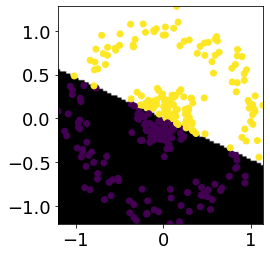

In [9]:
im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
plt.imshow(kernel_image, extent=im_extent, origin='lower', cmap='gray')

plt.scatter(X[:,0], X[:,1], c=class_lstsq)

So of course if we use data like this the linear classifier fails.

We are again going to use the kernel trick to create a feature space that allows for linear classification. But this time we are going to use the polynomial features. The second-order polynomial features are just defined by the pair-wise products of the first-order features, which is also the tensor product. We can just arrange the features from the tensor product into a higher-dimensional feature space, and perform linear classification in this feature space.

In [10]:
Xp = np.zeros((X.shape[0], 7))

for idx in range(X.shape[0]):
    ho_features = np.outer(X[idx, :], X[idx, :].T).ravel()
    
    Xp[idx,0] = X[idx,0]
    Xp[idx,1] = X[idx,1]
    Xp[idx,2] = ho_features[0]
    Xp[idx,3] = ho_features[1]
    Xp[idx,4] = ho_features[2]
    Xp[idx,5] = ho_features[3]
    Xp[idx,6] = 1
    

In [11]:
   
Wp_lstsq,resid,rank,sigma = np.linalg.lstsq(Xp, y_hot)

/var/folders/xn/hqbqng2d6nz8f1lcyd545kqr0000gn/T/ipykernel_7337/3280079181.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Wp_lstsq,resid,rank,sigma = np.linalg.lstsq(Xp, y_hot)


In [12]:
x_samples = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_samples = np.linspace(X[:,1].min(), X[:,1].max(), 100)

kernel_image = np.zeros((len(x_samples), len(y_samples)))

for ix, xv in enumerate(x_samples):
    for iy, yv in enumerate(y_samples):
        
        cc = np.argmax(np.dot([xv,yv, xv*xv, xv*yv, xv*yv, yv*yv, 1], Wp_lstsq))
        kernel_image[iy, ix] = cc
        
        

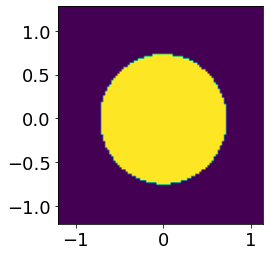

In [13]:
im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
plt.imshow(kernel_image, extent=im_extent, origin='lower')


In [14]:
classp_lstsq = np.argmax(np.dot(Xp, Wp_lstsq), axis=1)

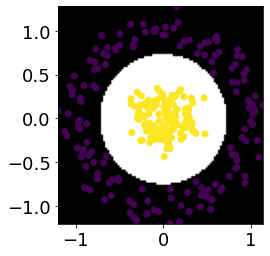

In [15]:
im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
plt.imshow(kernel_image, extent=im_extent, origin='lower', cmap='gray')

plt.scatter(X[:,0], X[:,1], c=classp_lstsq)

In [16]:
Wp_lstsq

array([[-0.0034807 ,  0.0034807 ],
       [ 0.01639095, -0.01639095],
       [ 0.97211965, -0.97211965],
       [ 0.00152848, -0.00152848],
       [ 0.00152848, -0.00152848],
       [ 0.9280019 , -0.9280019 ],
       [-0.01586566,  1.01586566]])

Right then if we look carefully at the above weights, then we can see what the classifier is doing and how it creates this circular boundary. We can see that there is a large positive weight for the $x^2$ (row 3) and $y^2$ (row 6) features in the first column, and then there are large negative weights for the $x^2$ and $y^2$ values in the second column, with a large positive weight in the constant row (row 7). 

So, we could even simplify this. Now, I'm just going to make this one feature based on $x^2 + y^2$. This is the only feature that the classifier is actually using. Then we can throw away the other info and get essentially the same result.


In [17]:
Xp2 = np.zeros((X.shape[0], 2))

for idx in range(X.shape[0]):
    ho_features = np.outer(X[idx, :], X[idx, :].T).ravel()
    
    Xp2[idx,0] = ho_features[0] + ho_features[3]
    Xp2[idx,1] = 1

In [18]:
   
Wp2_lstsq,resid,rank,sigma = np.linalg.lstsq(Xp2, y_hot)

/var/folders/xn/hqbqng2d6nz8f1lcyd545kqr0000gn/T/ipykernel_7337/3656968834.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Wp2_lstsq,resid,rank,sigma = np.linalg.lstsq(Xp2, y_hot)


In [19]:
x_samples = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_samples = np.linspace(X[:,1].min(), X[:,1].max(), 100)

kernel_image = np.zeros((len(x_samples), len(y_samples)))

for ix, xv in enumerate(x_samples):
    for iy, yv in enumerate(y_samples):
        
        #cc = np.argmax(np.dot([xv,yv, xv*xv, xv*yv, xv*yv, yv*yv, 1], Wp_lstsq))
        cc = np.argmax(np.dot([xv*xv + yv*yv,1], Wp2_lstsq))
        kernel_image[iy, ix] = cc
        
        

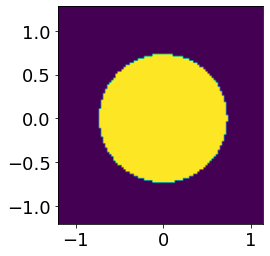

In [20]:
im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
plt.imshow(kernel_image, extent=im_extent, origin='lower')


In [21]:
classp2_lstsq = np.argmax(np.dot(Xp2, Wp2_lstsq), axis=1)

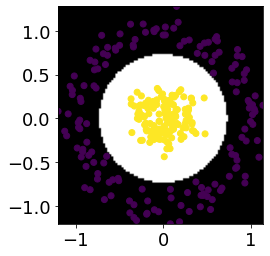

In [22]:
im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
plt.imshow(kernel_image, extent=im_extent, origin='lower', cmap='gray')

plt.scatter(X[:,0], X[:,1], c=classp_lstsq)

In [23]:
Wp2_lstsq

array([[ 0.94871673, -0.94871673],
       [-0.01513999,  1.01513999]])

In [24]:
decision_x = (Wp2_lstsq[1,1] - Wp2_lstsq[1,0]) / (Wp2_lstsq[0,0] - Wp2_lstsq[0,1])
print(decision_x)

0.5429860946130501


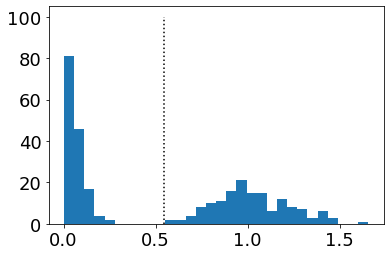

In [25]:
plt.hist([Xp2[:,0]], 30)
plt.plot([decision_x, decision_x], [0, 100], ':k')

## VSA Binding and the tensor product

So we can see how the polynomial features can be used to perform classification of data that is not linearly seperable. 

Next, I will show how the VSA binding operation also computes and represents the second-order features.

In [26]:
sidx = 7
ho_features = np.outer(X[sidx, :], X[sidx, :].T)

In [27]:
ho_features

array([[0.00142673, 0.00334075],
       [0.00334075, 0.00782251]])

In [28]:
N = 500
K = 10
# can encode the feature space into a vsa vector
vsaX = lccvec(N, 2, K)

vsa_features = vsaX.T @ X[sidx,:]

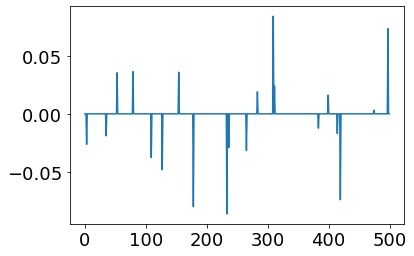

In [29]:
plt.plot(vsa_features.real)

In [30]:
# then this is the first order features recovered
vsa_reconX = np.real(np.conj(vsaX) @ vsa_features)/ K
print(vsa_reconX, X[sidx, :]) # there's always some crosstalk noise

[0.0377721  0.08844494] [0.0377721  0.08844494]


In [31]:
vsa_ho = lccbind(vsa_features, vsa_features, K)

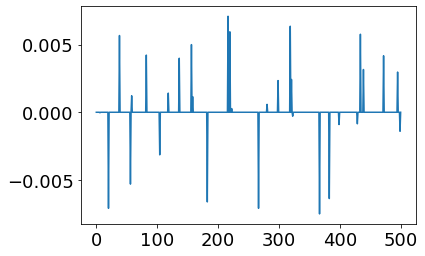

In [32]:
plt.plot(vsa_ho.real)

In [33]:
xx_code = lccbind(vsaX[0], vsaX[0], K)
xy_code = lccbind(vsaX[0], vsaX[1], K)
yy_code = lccbind(vsaX[1], vsaX[1], K)

vsa_recon_ho = np.zeros((2,2))

vsa_recon_ho[0,0] = np.real(np.conj(xx_code) @ vsa_ho)/ K

# this is actually encoded twice
vsa_recon_ho[0,1] = np.real(np.conj(xy_code) @ vsa_ho)/ K / 2
vsa_recon_ho[1,0] = np.real(np.conj(xy_code) @ vsa_ho)/ K / 2

vsa_recon_ho[1,1] = np.real(np.conj(yy_code) @ vsa_ho)/ K

In [34]:
vsa_recon_ho, ho_features

(array([[0.00142673, 0.00334075],
        [0.00334075, 0.00782251]]),
 array([[0.00142673, 0.00334075],
        [0.00334075, 0.00782251]]))

## VSA HO Feature classification

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


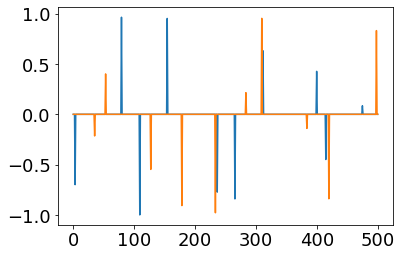

In [35]:
plt.plot(vsaX[0,:])
plt.plot(vsaX[1,:])

In [36]:
#vsaX = crvec(N,2)

In [37]:
vsa_features = vsaX.T @ X.T + lccI(N, K)[:,None] # the identity vector is like the bias term

In [38]:
vsa_features.shape

(500, 300)

In [39]:
vsa_ho = np.zeros_like(vsa_features)

for i in range(vsa_features.shape[1]):
    vsa_ho[:,i] = lccbind(vsa_features[:,i], vsa_features[:,i], K)
    #vsa_ho[:,i] = vsa_features[:,i] * vsa_features[:,i] + vsa_features[:,i]

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


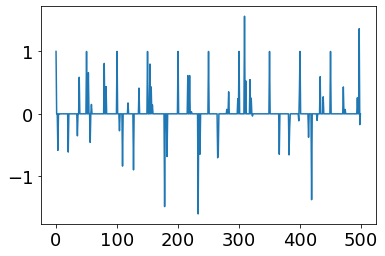

In [40]:
plt.plot(vsa_ho[:,10])

In [41]:
Wvsa_lstsq,resid,rank,sigma = np.linalg.lstsq(vsa_ho.T, y_hot, rcond=1e-1)

In [42]:
#Wvsa_lstsq = np.linalg.pinv(np.conj(vsa_ho) @ vsa_ho.T) @ np.conj(vsa_ho) @ y_hot

In [43]:
x_samples = np.linspace(X[:,0].min(), X[:,0].max(), 40)
y_samples = np.linspace(X[:,1].min(), X[:,1].max(), 40)

kernel_image = np.zeros((len(x_samples), len(y_samples)))

for ix, xv in enumerate(x_samples):
    for iy, yv in enumerate(y_samples):
        v_f = vsaX.T @ [xv, yv] + lccI(N, K)
        v_ho = lccbind(v_f, v_f, K)
        
        cc = np.argmax(np.dot(Wvsa_lstsq.T, v_ho))
        kernel_image[iy, ix] = cc
        
        

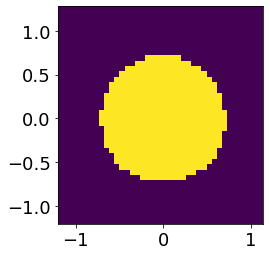

In [44]:
im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
plt.imshow(kernel_image, extent=im_extent, origin='lower')


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


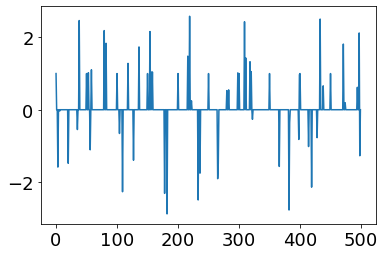

In [45]:
plt.plot(v_ho)